In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [1]:
import dataiku
from dataiku import pandasutils as pdu
import pandas as pd

/data/dataiku/dss_data/code-envs/python/QB_HCP_propensity_V6/lib/python3.6/site-packages/requests/__init__.py:104: RequestsDependencyWarning: urllib3 (1.26.15) or chardet (5.0.0)/charset_normalizer (2.0.12) doesn't match a supported version!
  RequestsDependencyWarning)


In [2]:
# Example: load a DSS dataset as a Pandas dataframe
hospital_mortality_data = dataiku.Dataset("Hospital_Mortality_Dataset")
hospital_mortality_data_df = hospital_mortality_data.get_dataframe()

In [3]:
random_state = 42


In [6]:
import numpy as np
import pandas as pd
import os
import gc
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import re
import math
# import keras
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
# from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import LocalOutlierFactor
from sklearn.base import BaseEstimator
from sklearn.base import TransformerMixin
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer
from sklearn.impute import IterativeImputer
from sklearn.inspection import permutation_importance
from sklearn.gaussian_process.kernels import RBF
from sklearn.gaussian_process.kernels import WhiteKernel
from sklearn.gaussian_process.kernels import ConstantKernel
from sklearn.gaussian_process.kernels import Matern
from sklearn.gaussian_process.kernels import RationalQuadratic
from sklearn.gaussian_process.kernels import ExpSineSquared
from sklearn.gaussian_process.kernels import DotProduct
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn import set_config
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import FunctionTransformer
from sklearn.naive_bayes import GaussianNB
# from keras.wrappers.scikit_learn import KerasClassifier
# from keras.callbacks import EarlyStopping
# from keras.layers import Dense
# from keras.layers import BatchNormalization
# from keras.layers import LayerNormalization
# from keras.layers import Dropout
# from keras.models import Sequential
# from keras.utils import np_utils
# from keras.utils.vis_utils import plot_model
from pandas.api.types import is_numeric_dtype
from itertools import product
from joblib import dump
from scipy import stats
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_selector
from sklearn.compose import make_column_transformer
# from yellowbrick.classifier import classification_report
# from yellowbrick.classifier import class_prediction_error
# from yellowbrick.classifier import confusion_matrix
# from yellowbrick.classifier import precision_recall_curve
# from yellowbrick.classifier.rocauc import roc_auc
# from yellowbrick.classifier.threshold import discrimination_threshold
# from yellowbrick.features import pca_decomposition
# from yellowbrick.features import rank1d
# from yellowbrick.features import rank2d
# from yellowbrick.target import balanced_binning_reference
# from yellowbrick.target import class_balance
# from yellowbrick.model_selection import learning_curve
# from yellowbrick.model_selection import feature_importances
# from yellowbrick.contrib.missing import MissingValuesBar
# from yellowbrick.contrib.missing import MissingValuesDispersion
# from yellowbrick.target.feature_correlation import feature_correlation

In [7]:
name = 'Hospital Mortality Prediction'
problem_type = 'classification'
data_size = 'small'


In [8]:
df = hospital_mortality_data_df

In [9]:
target_col = 'outcome'
# Thresholds & other parameters
threshold_NaN = 0.5
threshold_cat = 5
threshold_Z = 3.0
test_size = 0.33
threshold_entropy = 0.75
undersampling = False
undersampler = 'Random'
threshold_corr = 0.75
threshold_model = 5
threshold_score = 0.8
threshold_feature = 5
CPU = False
level_1_model = 'tree'
# Drop user's columns:
user_drop_cols = ['ID', 'CHD with no MI', 'COPD', 'INR', 'Lymphocyte', 'MCV', 'RBC']

In [12]:
df = df.loc[:, df.isnull().mean() < threshold_NaN]


In [13]:
df

,group,ID,outcome,age,gendera,BMI,hypertensive,atrialfibrillation,CHD with no MI,diabetes,deficiencyanemias,depression,Hyperlipemia,Renal failure,COPD,heart rate,Systolic blood pressure,Diastolic blood pressure,Respiratory rate,temperature,SP O2,Urine output,hematocrit,RBC,MCH,MCHC,MCV,RDW,Leucocyte,Platelets,Neutrophils,Basophils,Lymphocyte,PT,INR,NT-proBNP,Creatine kinase,Creatinine,Urea nitrogen,glucose,Blood potassium,Blood sodium,Blood calcium,Chloride,Anion gap,Magnesium ion,PH,Bicarbonate,Lactic acid,PCO2,EF
0,1,125047,0.0,72,1,37.588179,0,0,0,1,1,0,1,1,0,68.837838,155.866667,68.333333,16.621622,36.714286,98.394737,2155.0,26.272727,2.960000,28.250000,31.520000,89.900000,16.220000,7.650000,305.100000,74.65,0.40,13.30,10.600000,1.000000,1956.0,148.000000,1.958333,50.000000,114.636364,4.816667,138.750000,7.463636,109.166667,13.166667,2.618182,7.230,21.166667,0.5,40.0,55
1,1,139812,0.0,75,2,NaN,0,0,0,0,1,0,0,0,1,101.370370,140.000000,65.000000,20.851852,36.682540,96.923077,1425.0,30.780000,3.138000,31.060000,31.660000,98.200000,14.260000,12.740000,246.400000,NaN,NaN,NaN,NaN,NaN,2384.0,60.600000,1.122222,20.333333,147.500000,4.450000,138.888889,8.162500,98.444444,11.444444,1.887500,7.225,33.444444,0.5,78.0,55
2,1,109787,0.0,83,2,26.572634,0,0,0,0,1,0,0,1,0,72.318182,135.333333,61.375000,23.640000,36.453704,95.291667,2425.0,27.700000,2.620000,34.320000,31.300000,109.800000,23.820000,5.480000,204.200000,68.10,0.55,24.50,11.275000,0.950000,4081.0,16.000000,1.871429,33.857143,149.000000,5.825000,140.714286,8.266667,105.857143,10.000000,2.157143,7.268,30.571429,0.5,71.5,35
3,1,130587,0.0,43,2,83.264629,0,0,0,0,0,0,0,0,0,94.500000,126.400000,73.200000,21.857143,36.287037,93.846154,8760.0,36.637500,4.277500,26.062500,30.412500,85.625000,17.037500,8.225000,216.375000,81.80,0.15,14.50,27.066667,2.666667,668.0,85.000000,0.585714,15.285714,128.250000,4.386667,138.500000,9.476923,92.071429,12.357143,1.942857,7.370,38.571429,0.6,75.0,55
4,1,138290,0.0,75,2,31.824842,1,0,0,0,1,0,0,1,1,67.920000,156.560000,58.120000,21.360000,36.761905,99.280000,4455.0,29.933333,3.286667,30.666667,33.666667,91.000000,16.266667,8.833333,251.000000,NaN,NaN,NaN,NaN,NaN,30802.0,111.666667,1.950000,43.000000,145.750000,4.783333,136.666667,8.733333,104.500000,15.166667,1.650000,7.250,22.000000,0.6,50.0,55
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1172,2,171130,0.0,62,1,25.516870,1,1,0,1,0,1,1,1,0,100.125000,142.545455,69.681818,24.500000,37.055556,94.130435,NaN,33.628571,3.685714,27.842857,30.542857,91.142857,15.557143,7.742857,251.857143,81.55,0.70,10.65,12.600000,1.200000,47985.0,129.500000,8.385714,48.000000,120.000000,5.557143,136.714286,10.271429,94.428571,20.142857,2.714286,NaN,27.714286,NaN,NaN,40
1173,2,101659,0.0,78,1,25.822710,0,1,0,1,0,1,1,1,0,114.640000,101.222222,51.888889,18.958333,35.972222,93.526316,NaN,28.715789,3.270000,29.772727,33.263636,89.545455,18.672727,22.309091,283.000000,84.58,0.80,7.70,18.721429,1.692857,48044.0,34.000000,1.900000,34.500000,138.333333,4.520000,135.680000,10.523529,101.720000,18.160000,2.012500,NaN,20.480000,NaN,NaN,30
1174,2,162069,0.0,85,2,23.891779,1,1,0,1,1,0,0,1,0,52.720000,137.791667,40.958333,18.680000,36.777778,98.800000,118.0,27.685714,3.065714,26.900000,29.800000,90.285714,17.285714,9.228571,409.285714,65.90,0.40,24.40,13.000000,1.100000,50976.0,98.000000,2.728571,30.428571,99.000000,4.100000,136.000000,8.466667,97.285714,14.000000,2.028571,NaN,28.857143,NaN,NaN,55
1175,2,120967,0.0,79,2,35.288554,0,0,1,1,1,1,1,1,0,93.400000,94.416667,62.458333,22.040000,36.422222,99.560000,2585.0,33.537500,3.446250,31.150000,32.012500,97.375000,16.000000,6.062500,307.375000,79.85,0.30,13.20,16.442857,1.485714,59701.0,24.333333,1.736364,35.500000,135.166667,4.091667,140.000000,8.183333,104.000000,15.750000,2.090000,NaN,24.375000,NaN,NaN,25


In [14]:
cls_0=df[df[target_col]==0]
cls_1=df[df[target_col]==1]
df_class_1_over = cls_1.sample(250, replace=True)
df_class_0_over = cls_0.sample(250, replace=True)
df = pd.concat([df_class_0_over, df_class_1_over], axis=0)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 500 entries, 768 to 492
Data columns (total 51 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   group                     500 non-null    int64  
 1   ID                        500 non-null    int64  
 2   outcome                   500 non-null    float64
 3   age                       500 non-null    int64  
 4   gendera                   500 non-null    int64  
 5   BMI                       393 non-null    float64
 6   hypertensive              500 non-null    int64  
 7   atrialfibrillation        500 non-null    int64  
 8   CHD with no MI            500 non-null    int64  
 9   diabetes                  500 non-null    int64  
 10  deficiencyanemias         500 non-null    int64  
 11  depression                500 non-null    int64  
 12  Hyperlipemia              500 non-null    int64  
 13  Renal failure             500 non-null    int64  
 14  COPD    

In [27]:
df = df.dropna()
y = df[target_col]
X = df.drop(target_col, axis=1)
# Dimensions
nb_features = len(X.columns.tolist())
nb_targets = len(y.unique())
layer_size = nb_features + nb_targets + 2


In [29]:
# X_train, X_test, y_train, y_test = split(X, y, test_size=test_size, threshold_entropy=threshold_entropy, undersampling= undersampling, undersampler= undersampler, random_state = random_state)


In [30]:
from sklearn.model_selection import train_test_split

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [35]:
def evaluate_model(model, x_test, y_test):
    from sklearn import metrics

    # Predict Test Data 
    y_pred = model.predict(x_test)

    # Calculate accuracy, precision, recall, f1-score, and kappa score
    acc = metrics.accuracy_score(y_test, y_pred)
    prec = metrics.precision_score(y_test, y_pred)
    rec = metrics.recall_score(y_test, y_pred)
    f1 = metrics.f1_score(y_test, y_pred)
    kappa = metrics.cohen_kappa_score(y_test, y_pred)

    # Calculate area under curve (AUC)
    y_pred_proba = model.predict_proba(x_test)[::,1]
    fpr, tpr, _ = metrics.roc_curve(y_test, y_pred_proba)
    auc = metrics.roc_auc_score(y_test, y_pred_proba)

    # Display confussion matrix
    cm = metrics.confusion_matrix(y_test, y_pred)

    return {'acc': acc, 'prec': prec, 'rec': rec, 'f1': f1, 'kappa': kappa, 
            'fpr': fpr, 'tpr': tpr, 'auc': auc, 'cm': cm}


In [36]:
from sklearn import tree

# Building Decision Tree model 
dtc = tree.DecisionTreeClassifier(random_state=0)
dtc.fit(X_train, y_train)

# Evaluate Model
dtc_eval = evaluate_model(dtc, X_test, y_test)

# Print result
print('Accuracy:', dtc_eval['acc'])
print('Precision:', dtc_eval['prec'])
print('Recall:', dtc_eval['rec'])
print('F1 Score:', dtc_eval['f1'])
print('Cohens Kappa Score:', dtc_eval['kappa'])
print('Area Under Curve:', dtc_eval['auc'])
print('Confusion Matrix:\n', dtc_eval['cm'])

Accuracy: 0.875
Precision: 0.8387096774193549
Recall: 0.9629629629629629
F1 Score: 0.896551724137931
Cohens Kappa Score: 0.7405405405405405
Area Under Curve: 0.8624338624338623
Confusion Matrix:
 [[16  5]
 [ 1 26]]


In [38]:
from sklearn.ensemble import RandomForestClassifier

# Building Random Forest model 
rf = RandomForestClassifier(random_state=0)
rf.fit(X_train, y_train)

# Evaluate Model
rf_eval = evaluate_model(rf, X_test, y_test)

# Print result
print('Accuracy:', rf_eval['acc'])
print('Precision:', rf_eval['prec'])
print('Recall:', rf_eval['rec'])
print('F1 Score:', rf_eval['f1'])
print('Cohens Kappa Score:', rf_eval['kappa'])
print('Area Under Curve:', rf_eval['auc'])
print('Confusion Matrix:\n', rf_eval['cm'])

Accuracy: 0.875
Precision: 0.8181818181818182
Recall: 1.0
F1 Score: 0.9
Cohens Kappa Score: 0.7377049180327868
Area Under Curve: 0.9841269841269842
Confusion Matrix:
 [[15  6]
 [ 0 27]]


In [40]:
from sklearn.naive_bayes import GaussianNB

# Building Naive Bayes model 
nb = GaussianNB()
nb.fit(X_train, y_train)

# Evaluate Model
nb_eval = evaluate_model(nb, X_test, y_test)

# Print result
print('Accuracy:', nb_eval['acc'])
print('Precision:', nb_eval['prec'])
print('Recall:', nb_eval['rec'])
print('F1 Score:', nb_eval['f1'])
print('Cohens Kappa Score:', nb_eval['kappa'])
print('Area Under Curve:', nb_eval['auc'])
print('Confusion Matrix:\n', nb_eval['cm'])

Accuracy: 0.8125
Precision: 0.9090909090909091
Recall: 0.7407407407407407
F1 Score: 0.8163265306122449
Cohens Kappa Score: 0.6288659793814433
Area Under Curve: 0.8324514991181657
Confusion Matrix:
 [[19  2]
 [ 7 20]]


In [41]:
from sklearn.neighbors import KNeighborsClassifier

# Building KNN model 
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
# Evaluate Model
knn_eval = evaluate_model(knn, X_test, y_test)

# Print result
print('Accuracy:', knn_eval['acc'])
print('Precision:', knn_eval['prec'])
print('Recall:', knn_eval['rec'])
print('F1 Score:', knn_eval['f1'])
print('Cohens Kappa Score:', knn_eval['kappa'])
print('Area Under Curve:', knn_eval['auc'])
print('Confusion Matrix:\n', knn_eval['cm'])

Accuracy: 0.6041666666666666
Precision: 0.6111111111111112
Recall: 0.8148148148148148
F1 Score: 0.6984126984126984
Cohens Kappa Score: 0.15555555555555556
Area Under Curve: 0.5731922398589065
Confusion Matrix:
 [[ 7 14]
 [ 5 22]]


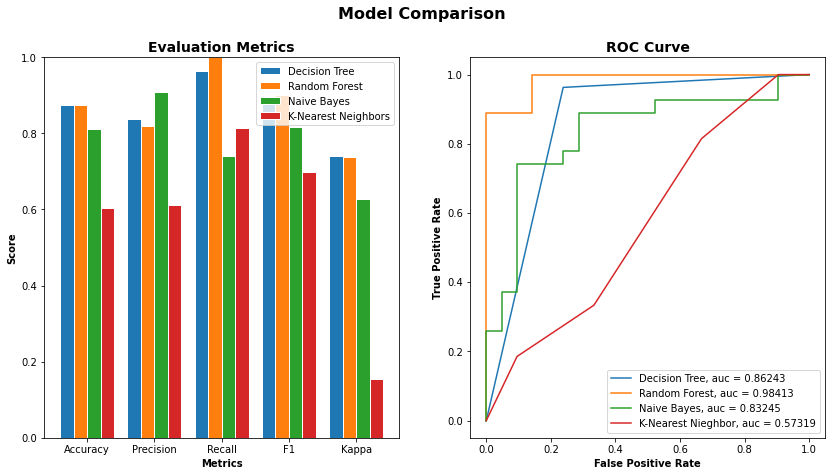

In [42]:
 # Intitialize figure with two plots
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Model Comparison', fontsize=16, fontweight='bold')
fig.set_figheight(7)
fig.set_figwidth(14)
fig.set_facecolor('white')

# First plot
## set bar size
barWidth = 0.2
dtc_score = [dtc_eval['acc'], dtc_eval['prec'], dtc_eval['rec'], dtc_eval['f1'], dtc_eval['kappa']]
rf_score = [rf_eval['acc'], rf_eval['prec'], rf_eval['rec'], rf_eval['f1'], rf_eval['kappa']]
nb_score = [nb_eval['acc'], nb_eval['prec'], nb_eval['rec'], nb_eval['f1'], nb_eval['kappa']]
knn_score = [knn_eval['acc'], knn_eval['prec'], knn_eval['rec'], knn_eval['f1'], knn_eval['kappa']]

## Set position of bar on X axis
r1 = np.arange(len(dtc_score))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]
r4 = [x + barWidth for x in r3]

## Make the plot
ax1.bar(r1, dtc_score, width=barWidth, edgecolor='white', label='Decision Tree')
ax1.bar(r2, rf_score, width=barWidth, edgecolor='white', label='Random Forest')
ax1.bar(r3, nb_score, width=barWidth, edgecolor='white', label='Naive Bayes')
ax1.bar(r4, knn_score, width=barWidth, edgecolor='white', label='K-Nearest Neighbors')

## Configure x and y axis
ax1.set_xlabel('Metrics', fontweight='bold')
labels = ['Accuracy', 'Precision', 'Recall', 'F1', 'Kappa']
ax1.set_xticks([r + (barWidth * 1.5) for r in range(len(dtc_score))], )
ax1.set_xticklabels(labels)
ax1.set_ylabel('Score', fontweight='bold')
ax1.set_ylim(0, 1)

## Create legend & title
ax1.set_title('Evaluation Metrics', fontsize=14, fontweight='bold')
ax1.legend()

# Second plot
## Comparing ROC Curve
ax2.plot(dtc_eval['fpr'], dtc_eval['tpr'], label='Decision Tree, auc = {:0.5f}'.format(dtc_eval['auc']))
ax2.plot(rf_eval['fpr'], rf_eval['tpr'], label='Random Forest, auc = {:0.5f}'.format(rf_eval['auc']))
ax2.plot(nb_eval['fpr'], nb_eval['tpr'], label='Naive Bayes, auc = {:0.5f}'.format(nb_eval['auc']))
ax2.plot(knn_eval['fpr'], knn_eval['tpr'], label='K-Nearest Nieghbor, auc = {:0.5f}'.format(knn_eval['auc']))

## Configure x and y axis
ax2.set_xlabel('False Positive Rate', fontweight='bold')
ax2.set_ylabel('True Positive Rate', fontweight='bold')

## Create legend & title
ax2.set_title('ROC Curve', fontsize=14, fontweight='bold')
ax2.legend(loc=4)

plt.show()

### Model Optimisation


On the next part of this notebook, we will try to optimise our RandomForest model by tuning the hyper parameters available from the scikit-learn library. After finding the optimal parameters we will then evaluate our new model by comparing it against our base line model before.

Tuning Hyperparameter with GridSearchCV
We will use GridSearchCV functionality from sklearn to find the optimal parameter for our model. We will provide our baseline model (named rf_grids), scoring method (in our case we will use recall as explained before), and also various parameters value we want to try with our model. The GridSearchCV function will then iterate through each parameters combination to find the best scoring parameters.

This function also allow us to use cross validation to train our model, where on each iteration our data will be divided into 5 (the number are adjustable from the parameter) fold. The models then will be trained on 4/5 fold of the data leaving the final fold as validation data, this process will be repeated for 5 times until all of our folds are used as validation data.


To see the result of which parameters combination works best we can access the best_params_ attribute from our grid search object.

Note: The more combination provided, the longer the process will take. Alternatively, you can also try RandomizedSearchCV to only randomly select specified number of parameters which can result in faster running time.

In [43]:
from sklearn.model_selection import GridSearchCV

# Create the parameter grid based on the results of random search 
param_grid = {
    'max_depth': [50, 80, 100],
    'max_features': [2, 3, 4],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 300, 500]
}

# Create a base model
rf_grids = RandomForestClassifier(random_state=0)

# Initiate the grid search model
grid_search = GridSearchCV(estimator=rf_grids, param_grid=param_grid, scoring='recall',
                           cv=5, n_jobs=-1, verbose=2)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

grid_search.best_params_

Fitting 5 folds for each of 243 candidates, totalling 1215 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:    6.7s
[Parallel(n_jobs=-1)]: Done 301 tasks      | elapsed:   14.4s
[Parallel(n_jobs=-1)]: Done 584 tasks      | elapsed:   25.2s
[Parallel(n_jobs=-1)]: Done 949 tasks      | elapsed:   39.1s
[Parallel(n_jobs=-1)]: Done 1215 out of 1215 | elapsed:   49.4s finished


{'max_depth': 50,
 'max_features': 4,
 'min_samples_leaf': 3,
 'min_samples_split': 8,
 'n_estimators': 100}

### Evaluating Optimised Model


After finding the best parameter for the model we can access the best_estimator_ attribute of the GridSearchCV object to save our optimised model into variable called best_grid. We will calculate the 6 evaluation metrics using our helper function to compare it with our base model on the next step.

In [44]:
# Select best model with best fit
best_grid = grid_search.best_estimator_

# Evaluate Model
best_grid_eval = evaluate_model(best_grid, X_test, y_test)

# Print result
print('Accuracy:', best_grid_eval['acc'])
print('Precision:', best_grid_eval['prec'])
print('Recall:', best_grid_eval['rec'])
print('F1 Score:', best_grid_eval['f1'])
print('Cohens Kappa Score:', best_grid_eval['kappa'])
print('Area Under Curve:', best_grid_eval['auc'])
print('Confusion Matrix:\n', best_grid_eval['cm'])

Accuracy: 0.9166666666666666
Precision: 0.8709677419354839
Recall: 1.0
F1 Score: 0.9310344827586207
Cohens Kappa Score: 0.827027027027027
Area Under Curve: 0.9647266313932981
Confusion Matrix:
 [[17  4]
 [ 0 27]]


### Model Comparison


The code below will draw the same plot as before only with our original Random Forest model and it's optimised version. It will also print the change on each evaluation metrics to help us see if our optimised model work better than the original one.

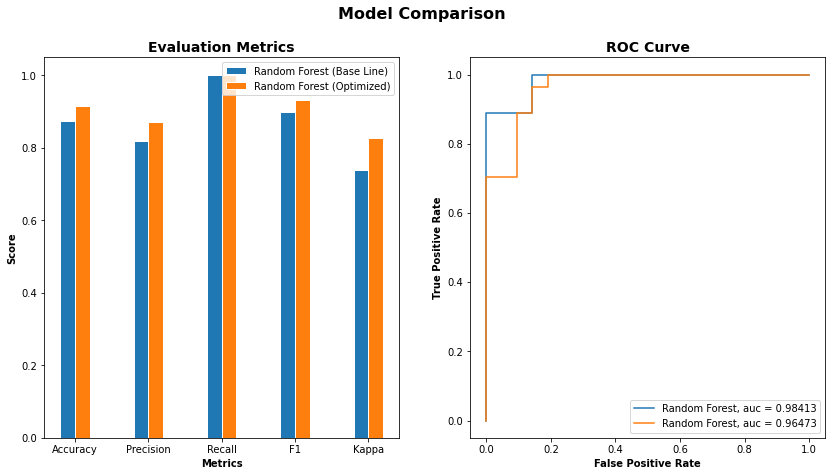

Change of 4.76% on accuracy.
Change of 6.45% on precision.
Change of 0.00% on recall.
Change of 3.45% on F1 score.
Change of 12.11% on Kappa score.
Change of -1.97% on AUC.


In [45]:
# Intitialize figure with two plots
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Model Comparison', fontsize=16, fontweight='bold')
fig.set_figheight(7)
fig.set_figwidth(14)
fig.set_facecolor('white')

# First plot
## set bar size
barWidth = 0.2
rf_score = [rf_eval['acc'], rf_eval['prec'], rf_eval['rec'], rf_eval['f1'], rf_eval['kappa']]
best_grid_score = [best_grid_eval['acc'], best_grid_eval['prec'], best_grid_eval['rec'], best_grid_eval['f1'], best_grid_eval['kappa']]

## Set position of bar on X axis
r1 = np.arange(len(rf_score))
r2 = [x + barWidth for x in r1]

## Make the plot
ax1.bar(r1, rf_score, width=barWidth, edgecolor='white', label='Random Forest (Base Line)')
ax1.bar(r2, best_grid_score, width=barWidth, edgecolor='white', label='Random Forest (Optimized)')

## Add xticks on the middle of the group bars
ax1.set_xlabel('Metrics', fontweight='bold')
labels = ['Accuracy', 'Precision', 'Recall', 'F1', 'Kappa']
ax1.set_xticks([r + (barWidth * 0.5) for r in range(len(dtc_score))], )
ax1.set_xticklabels(labels)
ax1.set_ylabel('Score', fontweight='bold')
# ax1.set_ylim(0, 1)

## Create legend & Show graphic
ax1.set_title('Evaluation Metrics', fontsize=14, fontweight='bold')
ax1.legend()

# Second plot
## Comparing ROC Curve
ax2.plot(rf_eval['fpr'], rf_eval['tpr'], label='Random Forest, auc = {:0.5f}'.format(rf_eval['auc']))
ax2.plot(best_grid_eval['fpr'], best_grid_eval['tpr'], label='Random Forest, auc = {:0.5f}'.format(best_grid_eval['auc']))

ax2.set_title('ROC Curve', fontsize=14, fontweight='bold')
ax2.set_xlabel('False Positive Rate', fontweight='bold')
ax2.set_ylabel('True Positive Rate', fontweight='bold')
ax2.legend(loc=4)

plt.show()

print('Change of {:0.2f}% on accuracy.'.format(100 * ((best_grid_eval['acc'] - rf_eval['acc']) / rf_eval['acc'])))
print('Change of {:0.2f}% on precision.'.format(100 * ((best_grid_eval['prec'] - rf_eval['prec']) / rf_eval['prec'])))
print('Change of {:0.2f}% on recall.'.format(100 * ((best_grid_eval['rec'] - rf_eval['rec']) / rf_eval['rec'])))
print('Change of {:0.2f}% on F1 score.'.format(100 * ((best_grid_eval['f1'] - rf_eval['f1']) / rf_eval['f1'])))
print('Change of {:0.2f}% on Kappa score.'.format(100 * ((best_grid_eval['kappa'] - rf_eval['kappa']) / rf_eval['kappa'])))
print('Change of {:0.2f}% on AUC.'.format(100 * ((best_grid_eval['auc'] - rf_eval['auc']) / rf_eval['auc'])))

Output
We have our model, what next? As data scientist it's important to be able to develop a model with good re-usability. In this final part I will explain on how to create a prediction based on new data and also how to save (and load) your model using joblib so you can use it in production or just save it for later use without having to repeat the whole process.



## Prediction

In this step we will predict the expected outcome of all the row from our dataset then save it into a csv file for easier access in the future.

In [50]:
feature = X

df['risk_prediction'] = rf.predict(feature)

df['risk_prediction'] = df['risk_prediction'].apply(lambda x: 'yes' if x==0 else 'no')

# Save new dataframe into csv file
df.to_csv('risk_prediction.csv', index=False)

df.head(10)

,group,ID,outcome,age,gendera,BMI,hypertensive,atrialfibrillation,CHD with no MI,diabetes,deficiencyanemias,depression,Hyperlipemia,Renal failure,COPD,heart rate,Systolic blood pressure,Diastolic blood pressure,Respiratory rate,temperature,SP O2,Urine output,hematocrit,RBC,MCH,MCHC,MCV,RDW,Leucocyte,Platelets,Neutrophils,Basophils,Lymphocyte,PT,INR,NT-proBNP,Creatine kinase,Creatinine,Urea nitrogen,glucose,Blood potassium,Blood sodium,Blood calcium,Chloride,Anion gap,Magnesium ion,PH,Bicarbonate,Lactic acid,PCO2,EF,risk_prediction
125,1,139946,0.0,53,2,41.935568,1,1,0,0,1,0,0,1,0,97.454545,130.619048,75.476190,17.045455,36.541666,96.000000,1745.0,31.614286,3.861429,25.557143,31.271429,81.714286,16.671429,8.600000,253.285714,79.500000,0.350000,11.650000,14.610000,1.460000,4537.0,47.333333,3.320000,54.300000,146.000000,4.470000,140.300000,8.925000,102.300000,14.800000,2.275000,7.400000,27.800000,1.100000,50.000000,55,yes
885,2,141181,0.0,84,2,24.330612,0,1,1,0,0,1,1,0,1,84.541667,110.250000,54.958333,24.678571,36.666667,97.625000,1285.0,33.750000,3.611250,30.387500,32.550000,93.250000,14.000000,13.300000,195.375000,88.900000,0.133333,6.300000,13.575000,1.175000,4838.0,123.000000,0.650000,22.000000,119.400000,4.100000,141.875000,8.180000,104.750000,11.875000,2.140000,7.341429,29.250000,1.200000,55.142857,40,yes
244,1,110660,0.0,50,1,23.724537,0,0,0,1,0,0,0,0,0,77.520000,146.375000,64.166667,17.967742,38.098765,97.320000,2995.0,32.212500,3.537500,30.100000,33.062500,91.125000,13.987500,11.962500,311.750000,84.150000,0.450000,10.000000,13.050000,1.100000,1675.0,77.333333,0.975000,17.666667,204.800000,3.733333,143.000000,7.881818,105.083333,12.916667,2.127273,7.436667,28.833333,1.400000,47.666667,55,yes
912,2,158457,0.0,84,2,27.943088,1,1,0,0,0,0,1,0,0,56.407407,106.851852,57.814815,17.600000,36.966666,98.774194,1761.0,30.700000,4.128571,23.385714,31.342857,74.428571,19.971429,14.114286,572.714286,86.200000,0.600000,10.700000,24.850000,2.550000,2125.0,64.800000,1.242857,23.142857,145.000000,4.000000,140.142857,8.640000,104.000000,11.833333,2.180000,7.407778,28.500000,1.400000,43.888889,50,yes
380,1,187500,0.0,89,2,22.754557,1,1,0,0,0,0,0,0,0,82.458333,115.093750,54.500000,18.129032,37.027778,98.750000,952.0,30.812500,3.433750,28.525000,31.800000,89.750000,15.012500,11.050000,346.000000,85.700000,0.300000,7.900000,12.520000,1.080000,6049.0,47.500000,0.611111,13.777778,92.000000,3.981818,141.444444,9.066667,108.111111,14.111111,2.011111,7.356667,23.333333,1.700000,38.000000,55,yes
260,1,136977,0.0,69,2,49.461451,1,1,0,1,1,0,1,1,0,90.275862,90.200000,45.520000,20.896552,36.300000,98.866667,0.0,30.116667,3.587778,27.177778,31.855556,85.555556,18.277778,6.822222,114.600000,69.000000,0.900000,19.900000,14.585714,1.257143,25045.0,149.000000,3.205263,21.526316,111.800000,4.212000,135.120000,9.350000,95.320000,16.480000,1.900000,7.311667,27.480000,1.400000,57.000000,25,yes
1064,2,103886,0.0,75,2,32.818074,1,1,0,0,0,0,1,0,0,85.031250,125.357143,69.148148,18.102564,37.150000,97.437500,416.0,31.100000,3.090000,32.766667,32.555556,100.666667,13.544444,16.255556,383.777778,93.150000,0.150000,4.250000,21.700000,2.077778,5705.0,51.500000,0.955556,30.888889,172.666667,4.300000,144.222222,8.814286,105.000000,14.333333,2.071429,7.415000,29.222222,2.814286,44.583333,55,yes
898,2,195182,0.0,56,2,28.078669,1,0,0,0,1,0,1,1,0,75.920000,112.416667,65.333333,28.760000,35.916667,93.320000,250.0,23.718750,2.770000,29.128571,33.407143,87.285714,14.450000,13.171429,405.428571,90.233333,0.300000,5.783333,13.600000,1.177778,33133.0,188.600000,2.836364,31.272727,216.666667,4.334783,129.521739,7.976471,97.043478,16.956522,2.112500,7.310000,19.869565,1.294286,29.555556,55,no
92,1,144913,0.0,65,2,53.621933,0,1,0,0,0,0,0,0,0,93.560000,104.172414,61.172414,17.812500,36.984127,94.760000,1728.0,30.820000,3.427778,28.733333,32.100000,89.666667,17.500000,3.122222,144.555556,71.955556,0.287500,20.722222,13.350000,1.125000,2954.0,29.666667,1.173333,47.666667,176.000000,3.8533

In [51]:
from joblib import dump, load

# Saving model
dump(rf, 'risk_prediction_classification.joblib')
# Loading model
# clf = load('bank_deposit_classification.joblib') 

['risk_prediction_classification.joblib']